<a href="https://colab.research.google.com/github/NguyenHieu201/MultiSrcTL/blob/main/MultiSrcTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [1]:
!pip install qpsolvers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 4.7 MB/s 
     |████████████████████████████████| 121 kB 13.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for quadprog: filename=quadprog-0.1.11-cp37-cp37m-linux_x86_64.whl size=290758 sha256=7d1d27fee0a0495cdbdabd763356e4b0e95eaff64d259dcb6e99a6988c9e5142
  Stored in directory: /root/.cache/pip/wheels/4a/4e/d7/41034ea11aeef1266df3cae546116cb6094e955c41ae3e2589
Successfully built quadprog


In [85]:
import keras
import pandas as pd
import os
import glob
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import rbf_kernel
from qpsolvers import solve_qp
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


# Domain

## Class and function ultility

In [3]:
class DataProcessing():
    @staticmethod
    def read_csv(data_path, del_cols):
        df = pd.read_csv(data_path, index_col=[0])
        for col in del_cols:
            del df[col]
        return df.to_numpy()

    @staticmethod
    def sliding_window_data(data_array, sliding_window):
        n_data = data_array.shape[0]
        data_input = []
        label = []
        for i in range(n_data - sliding_window):
            new_data = []
            for j in range(i, i+sliding_window-1):
                new_data = new_data + data_array[j].tolist()
            data_input.append(new_data)
            label.append(data_array[i+sliding_window-1].tolist())
        return {
            'data_input': np.array(data_input), 
            'label':np.array(label)
        }

    @staticmethod
    def split_label_data(n_un, data_input, label):
        # la_input, un_input, la_output, un_output = train_test_split(data_input, label, 
        #                                                             test_size=n_un, random_state=42)
        n_la = data_input.shape[0] - n_un
        la_input, un_input = data_input[:n_la], data_input[n_la:]
        la_output = label[:n_la]
        un_output = label[n_la:]
        return {
            'unlabel_data': un_input,
            'label_data': la_input,
            'label': la_output,
            'un_output': un_output
        }

    @staticmethod
    def mmd_test(source_data, target_data, gamma=1000):
        n_source = source_data.shape[0]
        n_target = target_data.shape[0]

        all_data = np.concatenate((source_data, target_data))
        min_X = np.min(all_data, axis=0)
        max_X = np.max(all_data, axis=0)
        
        source_copy = (source_data - min_X) / (max_X - min_X)
        target_copy = (source_data - min_X) / (max_X - min_X)

        ss_pairwise = rbf_kernel(X=source_copy, gamma=gamma)
        tt_pairwise = rbf_kernel(X=target_copy, gamma=gamma)
        st_pairwise = rbf_kernel(X=source_copy, Y=target_copy, gamma=gamma)

        P = ss_pairwise / (n_source * n_source)
        q = np.sum(st_pairwise, axis=1) / (n_source * n_target) * (-1)
        G = np.identity(n_source) * -1
        h = np.zeros((n_source, ))

        solve = solve_qp(P, q, G, h)
        return ss_pairwise, st_pairwise, tt_pairwise, solve

In [4]:
def SVR_decision_boundary(model):
    support_vectors = model.support_vectors_
    alpha = model.dual_coef_
    predict = model.predict(support_vectors)
    tmp = predict.T * alpha
    boundary = support_vectors * (tmp.T)
    boundary = np.sum(boundary, axis=0)
    omega = np.linalg.norm(boundary)
    return omega

In [5]:
class SourceDomain():
    def __init__(self, X, y, kernel_pairwise=rbf_kernel, model=None, scaler=MinMaxScaler):
        self.X = X
        self.Y = y
        self.kernel = kernel_pairwise
        self.model = model

        self.n_data = X.shape[0]

        self.X_scaler = scaler()
        self.Y_scaler = scaler()


    def scale_data(self):
        self.X_scaler.fit(X=self.X)
        self.Y_scaler.fit(X=self.Y)

    def weight_data(self, target_data, gamma=10000):
        ss_pairwise, st_pairwise, tt_pairwise, self.v = DataProcessing.mmd_test(source_data=self.X, 
                                                                                target_data=target_data,
                                                                                gamma=gamma)
        
        self.mmd = np.matmul(np.matmul(self.v.T, ss_pairwise), self.v) - 2 * np.sum(np.matmul(st_pairwise.T, self.v)) + np.sum(tt_pairwise)
        self.mmd = float(np.sqrt(self.mmd))

    def fit_model(self):
        X = self.X_scaler.transform(self.X)
        y = self.Y_scaler.transform(self.Y)
        self.model.fit(X=X, y=y.ravel(), 
                       sample_weight=self.v)
        self.omega = SVR_decision_boundary(self.model)

    def hypothesis(self, input_predict):
        predict_data = self.X_scaler.transform(X=input_predict)
        predict_value = self.model.predict(X=predict_data)
        predict_scale_value = self.Y_scaler.inverse_transform(X=predict_value.reshape((1, -1)))
        return predict_scale_value.reshape((-1, 1))

    def distance_boundary(self, predict_value):
        return abs(predict_value) / self.omega

# MultiSrcTL

In [45]:
class MultiSrcTL():
    def __init__(self, source_list, target_domain=None, BETA=0.001):
        self.source_list = source_list
        self.target_domain = target_domain

        self.n_domain = len(source_list)
        self.BETA = BETA

    def empirical_error(self, src_i, src_j):
        input_data = src_i.X_scaler.transform(X=src_i.X)
        y_pred = src_j.model.predict(X=input_data)
        y_true = src_i.Y_scaler.transform(X=src_i.Y)
        R_square = r2_score(y_true=y_true, y_pred=y_pred)
        return R_square * self.BETA

    def compute_inter_src_relation_matrix(self):
        error_matrix = np.zeros((self.n_domain, self.n_domain))
        for i in range(self.n_domain):
            for j in range(self.n_domain):
                if i == j:
                    continue
                else:
                    error_matrix[i, j] = self.empirical_error(src_i=self.source_list[i],
                                                              src_j=self.source_list[j])
    
        error_matrix = np.exp(error_matrix)
        relation_matrix = np.zeros((self.n_domain, self.n_domain))
        for i in range(self.n_domain):
            for j in range(self.n_domain):
                if i == j:
                    continue
                else:
                    relation_matrix[i, j] = error_matrix[i, j] / (np.sum(error_matrix[i, :]) - 1)
        self.source_matrix = relation_matrix

    def compute_source_target_relation(self, SIGMA=0.001, p=2):
        st_sim = np.zeros(shape=(self.n_domain, ))
        for i in range(self.n_domain):
            st_sim[i, ] = self.source_list[i].mmd

        st_sim = np.exp(np.power(st_sim, p) * SIGMA * -1)
        st_sum = np.sum(st_sim)
        st_sim = st_sim / (st_sum + 1e-6)
        self.st_sim = st_sim

    def compute_source_weight(self, SIGMA=0.7):
        # SIGMA = 1 / self.n_domain
        result = SIGMA * np.identity(self.n_domain) + (1 - SIGMA) * self.source_matrix
        result = np.matmul(self.st_sim.T, result)
        self.source_weight = result

    def source_domain_predict(self, data):
        predict_list = []
        for i in range(self.n_domain):
            predict_source_i = self.source_list[i].model.predict(data)
            predict_list.append(predict_source_i)
        return predict_list

    def predict(self, test_data, confidence=0.5):
        predict_test_data = []
        n_test = test_data.shape[0]
        predict_values = self.source_domain_predict(data=test_data)
        for i in range(n_test):
            domain_learn = np.zeros((self.n_domain, ))
            predict_value = np.zeros((self.n_domain, ))
            for t in range(self.n_domain):
                predict_value[t] = predict_values[t][i]
            for k in range(self.n_domain):
                conf = 0.01 / (0.01 + self.source_list[k].distance_boundary(predict_value[k]))
                if conf < confidence:
                    domain_learn[k] = (np.matmul(self.source_matrix[k, :].T, predict_value)
                                      - self.source_matrix[k, k] * predict_value[k])
                else:
                    domain_learn[k] = predict_value[k]
            
            result = np.sum(self.source_weight * domain_learn)
            predict_test_data.append(result)

        return np.array(predict_test_data).ravel()

In [88]:
# Using linear regression to scale data
def scale_data(y_pred, y_true):
    reg = LinearRegression()
    reg.fit(X=y_pred.reshape(-1, 1),
            y=y_true.reshape(-1, 1))
    y_pred_scale = reg.predict(y_pred.reshape(-1, 1))
    return reg

# Test

In [112]:
# Create target domain
# Split train-test with ratio 0.8/0.2
target_path = '/content/stock_data/data_for_student/GVR.csv'
df = pd.read_csv(target_path, index_col=[0])
del df['datetime']
del df['symbol']

data_pre = DataProcessing.sliding_window_data(data_array=df.to_numpy(), sliding_window=5)
number_train = int(df.shape[0] * 8 / 10)

train_data = data_pre['data_input'][:number_train]
test_data = data_pre['data_input'][number_train:]
test_label = data_pre['label'][number_train:]
train_label = data_pre['label'][:number_train]

In [113]:
def create_src_domain(src_path, model):
    src_df = pd.read_csv(src_path, index_col=[0])
    del src_df['datetime']
    del src_df['symbol']

    data_pre_src = DataProcessing.sliding_window_data(data_array=src_df.to_numpy(), sliding_window=5)

    src_data = data_pre_src['data_input']
    src_label = data_pre_src['label'] 
    src_domain = SourceDomain(X=src_data, y=src_label[:, 0].reshape(-1, 1),
                            model=model)

    src_domain.scale_data()
    src_domain.weight_data(target_data=train_data)
    src_domain.fit_model()
    return src_domain

In [114]:
src_dir = "/content/stock_data/data_for_teacher/"
src_list = []

for file_name in os.listdir(src_dir):
    domain = create_src_domain(src_path=src_dir + file_name,
                               model=SVR())
    src_list.append(domain)

In [115]:
train_scaler = MinMaxScaler()
train_scaler.fit(X=train_data)

test_input_data = train_scaler.transform(X=test_data)
train_input_data = train_scaler.transform(X=train_data)

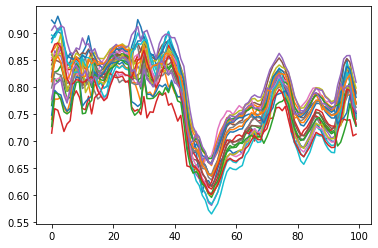

In [116]:
for domain in src_list:
    y_pred = domain.model.predict(X=test_input_data)
    plt.plot(y_pred)

In [117]:
mlti = MultiSrcTL(source_list=src_list, target_domain=train_data,
                  BETA=0.001)
mlti.compute_inter_src_relation_matrix()
mlti.compute_source_target_relation()
mlti.compute_source_weight()

In [118]:
# Train linear regression model to scale data
y_train_pred = mlti.predict(test_data=train_input_data)
y_train_true = train_label[:, 0]
scale_model = scale_data(y_pred=y_train_pred,
                         y_true=y_train_true)

In [119]:
y_pred = scale_model.predict(mlti.predict(test_data=test_input_data, confidence=0.1).reshape(-1, 1))
y_true = test_label[:, 0]

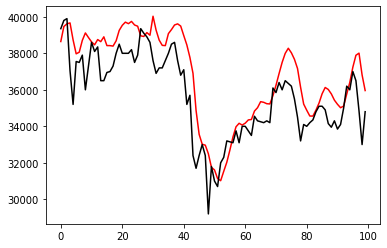

In [120]:
plt.plot(y_pred, 'r')
plt.plot(y_true, 'k')

# Stock Dataset

In [8]:
!git clone 'https://github.com/tien-nh/stock_data'

Cloning into 'stock_data'...
remote: Enumerating objects: 43, done.
remote: Total 43 (delta 0), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (43/43), done.
